This notebook contains data preprocessing, exploratory data analysis and model training steps for the LSTM project.

Given the large volume of dataset in production, the goal of this notebook is to have LSTM model trained on the large sample sequence dataset prepared in the previous step. 
Data pre-processing following the EDA step aims to downsize the dataset by decreasing the number of event categories included in the training. Since one-hot encoding is applied for embedding of the training data.

#### Check GPU Status

Sometimes even though we set up GPU cluster, GPU may not be active. Check to debug when necessary.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
import tensorflow as tf

tf.config.list_physical_devices('GPU')


2023-10-24 17:32:22.899671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 17:32:23.698047: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-24 17:32:23.698122: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-24 17:32:23.698129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [2]:
!nvidia-smi

Tue Oct 24 17:32:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000001:00:00.0 Off |                  Off |
| N/A   28C    P8     9W /  70W |      3MiB / 16127MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000002:00:00.0 Off |                  Off |
| N/A   

#### Install Packages

In [1]:
import pandas as pd
import numpy as np

from keras.layers import LSTM,Dense,Embedding
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder



2023-11-10 16:44:07.961564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 16:44:11.494723: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-10 16:44:11.494750: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-10 16:44:18.247717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

#### Read and Prepare Data

In this section, we read the n-item sequence dataset to pandas dataframe for data pre-processing.

Given the large data volume, we need to downsize the number of categories in the dataset, in order to mitigate the memory explosion issue in the one-hot encoding and/or fitting stage.

##### 5-item Seq

Start with the 5-item sequence as illustration. 

We first apply some exploratory data analysis for preprocessing decision.

In [2]:
df = pd.read_csv('seq51.csv', index_col=0)

In [3]:
df.head()

,0,1,2,3,4,y
0,42186,14418,42187,19930,18478,14801
1,14418,42187,19930,18478,14801,15016
2,42187,19930,18478,14801,15016,15712
3,19930,18478,14801,15016,15712,18544
4,18478,14801,15016,15712,18544,18259


<Axes: xlabel='y'>

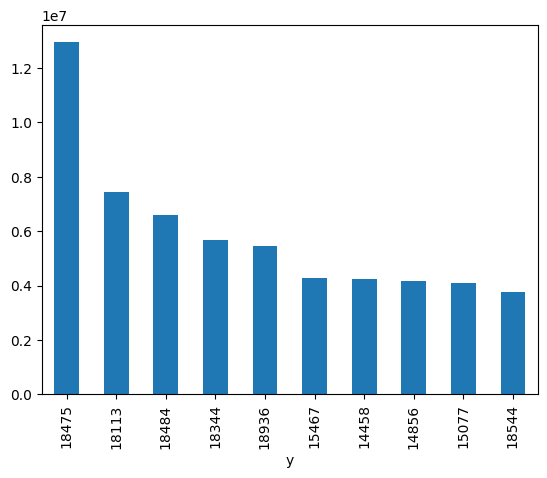

In [4]:
#bar chart to show the distribution of top 10 categories
flat = df.y
top = flat.map(str).value_counts().head(10)
top.plot(kind='bar')

In [5]:
#value count of unique categories
count = flat.value_counts() 
count

y
18475    12938537
18113     7427127
18484     6598698
18344     5685620
18936     5464472
           ...   
39704           1
11725           1
11726           1
11727           1
4782            1
Name: count, Length: 46721, dtype: int64

##### Percentage of top N event count to the whole population.
If top N event percentage exceeds a reasonable threshold, we consider top N as representation of the whole population, and make a new category for the rest events. In this way, number of categories can be downsized significantly, to same memory required during the fitting step.

In [44]:
lenall = len(flat)
top10 = count.head(10).sum()
top10/lenall

0.24065884147707506

*The percentage here is too low

In [45]:
top50 = count.head(50).sum()
top50/lenall

0.5894476913826477

*The percentage here is pretty reasonable

In [46]:
top100 = count.head(100).sum()
top100/lenall

0.7346651550682997

In [47]:
top150 = count.head(150).sum()
top150/lenall

0.8093614959424623

In [48]:
top500 = count.head(500).sum()
top500/lenall

0.9423751183428932

*The percentage is high but 500 categories is still too many.


In [6]:
top = pd.DataFrame(count.head(50),index=None)
t50 = top.index
t20 = pd.DataFrame(count.head(20),index=None).index

# At locations where the value is NOT in the top 50, 
# replace the category with 0
df.loc[~df['y'].isin(t20), 'y'] = 0

#Create categorical
#df['y'] = df['y'].astype(pd.CategoricalDtype(categories=df['y'].unique(),ordered=False))

In [7]:
for i in range(5):
    loc = str(i)
    # At locations where the neighborhood is NOT in the top 50, 
    # replace the category with 0
    df.loc[~df[loc].isin(t20), loc] = 0
    #Create categorical
    #df[loc] = df[loc].astype(pd.CategoricalDtype(categories=df[loc].unique(),ordered=False))

In [8]:
df.head(50)

,0,1,2,3,4,y
0,0,0,0,0,0,0
1,0,0,0,0,0,15016
2,0,0,0,0,15016,15712
3,0,0,0,15016,15712,18544
4,0,0,15016,15712,18544,0
5,0,15016,15712,18544,0,0
6,15016,15712,18544,0,0,0
7,15712,18544,0,0,0,0
8,18544,0,0,0,0,0
9,0,0,0,0,0,0


In [9]:
enc = OrdinalEncoder()
enc.fit(df)
data = enc.transform(df)


In [10]:
X = data[:,:5]
y = data[:,-1]
X

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  5.],
       ...,
       [ 0., 10.,  0.,  0.,  2.],
       [10.,  0.,  0.,  2., 12.],
       [ 0.,  0.,  2., 12., 20.]])

In [11]:
num_classes = len(np.unique(X))
print(num_classes)

21


In [12]:
y_encoded = to_categorical(y)
y_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.30, random_state=42)


In [16]:
X_train

array([[10.,  0., 13., 13.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 4.,  0., 16.,  0.,  0.],
       ...,
       [ 0.,  8.,  0.,  0.,  0.],
       [ 0., 10.,  0., 15.,  0.],
       [ 0., 14., 16.,  0.,  4.]])

In [17]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### LSTM 50

The first example model takes 50 LSTM nodes for training

In [14]:
#custom generator can be used to avoid the memory explosion, not illustrated in this notebook.
length = 50  # Length of the output sequences
batch_size = 10  # Number of timeseries samples in each batch
generator = TimeseriesGenerator(y_train, y_train, length=length, batch_size=batch_size)

In [18]:
# model parameters are specified here

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(num_classes, embedding_vector_length, input_length=5))
layer = LSTM(50, dropout=0.2)
model.add(layer)
dense = Dense(num_classes, activation='softmax')
model.add(dense)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())




2023-11-10 17:00:59.881587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-10 17:00:59.886397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-11-10 17:00:59.886462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-11-10 17:00:59.886520: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-11-10 17:00:59.886577: W tensorfl

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 32)             672       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dense (Dense)               (None, 21)                1071      
                                                                 
Total params: 18,343
Trainable params: 18,343
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

In [ ]:
history = model.fit(X_train, y_train, epochs=2,batch_size=1)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=

Epoch 1/2
   369818/170773140 [..............................] - ETA: 1293:03:08 - loss: 1.2444 - accuracy: 0.6733

In [ ]:

#summarize accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

#summarize loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

**Given the limited GPU cluster options in non-production environment for this illustration, the running result is not concrete. Please feel free to take the notebook as an example, create more capable GPU on your subscription and run with your own specified model configuration.**

### LSTM 100

Try LSTM model with 100 nodes if the one with 50 nodes goes through.

In [39]:
# Display of model

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(num_classes, embedding_vector_length, input_length=5))
layer = LSTM(100, dropout=0.2)
model.add(layer)
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 5, 32)             1632      
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 51)                5151      
                                                                 
Total params: 59,983
Trainable params: 59,983
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train,validation_split=0.2, epochs=50, batch_size=2)
print(history.history.keys())


Epoch 1/50
385454/385454 [==============================] - 1301s 3ms/step - loss: 2.7285 - accuracy: 0.3804 - val_loss: 2.7232 - val_accuracy: 0.3818
Epoch 2/50
385454/385454 [==============================] - 1232s 3ms/step - loss: 2.7254 - accuracy: 0.3805 - val_loss: 2.7223 - val_accuracy: 0.3812
Epoch 3/50
385454/385454 [==============================] - 1229s 3ms/step - loss: 2.7267 - accuracy: 0.3803 - val_loss: 2.7251 - val_accuracy: 0.3817
Epoch 4/50
385454/385454 [==============================] - 1229s 3ms/step - loss: 2.7279 - accuracy: 0.3803 - val_loss: 2.7260 - val_accuracy: 0.3814
Epoch 5/50
385454/385454 [==============================] - 1289s 3ms/step - loss: 2.7295 - accuracy: 0.3803 - val_loss: 2.7237 - val_accuracy: 0.3812

2023-10-13 17:59:29.188883: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 157265232 exceeds 10% of free system memory.
2023-10-13 17:59:29.276778: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 157265232 exceeds 10% of free system memory.
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output

In [ ]:

#summarize accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

#summarize loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

### lstm 500

In [ ]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(num_classes, embedding_vector_length, input_length=5))
model.add(LSTM(500))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
history = model.fit(X_train, y_train,validation_split=0.2, epochs=50, batch_size=256)
print(history.history.keys())

In [ ]:
import matplotlib.pyplot as plt
#summarize accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

#summarize loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

## 10-item Seq

In [2]:
df10 = pd.read_csv('seq10.csv', index_col=0)
df10.head()

,0,1,2,3,4,5,6,7,8,9,y
0,174580.0,11456.0,113899.0,21006.0,158341.0,11487.0,11477.0,11471.0,11462.0,11466.0,11470.0
1,11456.0,113899.0,21006.0,158341.0,11487.0,11477.0,11471.0,11462.0,11466.0,11470.0,4142.0
2,113899.0,21006.0,158341.0,11487.0,11477.0,11471.0,11462.0,11466.0,11470.0,4142.0,21742.0
3,21006.0,158341.0,11487.0,11477.0,11471.0,11462.0,11466.0,11470.0,4142.0,21742.0,11648.0
4,158341.0,11487.0,11477.0,11471.0,11462.0,11466.0,11470.0,4142.0,21742.0,11648.0,11475.0


In [3]:
enc = OrdinalEncoder()
enc.fit(df10)
data = enc.transform(df10)
X = data[:,:10]
y = data[:,-1]
num_classes = len(np.unique(y))
print(num_classes)

6345


In [4]:
y_encoded = to_categorical(y, num_classes=num_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)
X_train.shape

(4810895, 10)

In [5]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(num_classes, embedding_vector_length, input_length=10))
model.add(LSTM(100))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 32)            203040    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 6345)              640845    
                                                                 
Total params: 897,085
Trainable params: 897,085
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train,validation_split=0.2, epochs=50, batch_size=1)
print(history.history.keys())

In [ ]:
#summarize accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

#summarize loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

You may change the model configuration as experiment to get the satisfactory hyperparameters used for the end model.
